In [3]:
import xarray as xr
import pandas as pd
import os
import re
import sys
import glob
import pathlib
import datetime
import numpy as np
import scipy
import easygems.healpix as egh
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import scipy
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import string
alphabet = [f"({x}) " for x in string.ascii_lowercase]

import global3d_track as g3d
my_tools = g3d.scripts.src.utils.analysis_tools
src = g3d.scripts.src
import logging
from my_library.track_analyses import helpers
import pathlib

In [4]:
datadir = pathlib.Path(f'/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/')
savedir = pathlib.Path('../../extra_figures')
os.makedirs(savedir, exist_ok=True)
os.listdir(datadir/'dcc_statistics')

dpi = 300
ext = 'pdf'

In [5]:
files = list(datadir.glob("dcc_statistics/*.nc"))
ds = xr.open_mfdataset(files, concat_dim='system', combine='nested', decode_times=False)
ds['lifetime_hours'] = (ds['lifetime']*np.timedelta64(1, "s")) / np.timedelta64(1, "h")

#### core velocity and depth

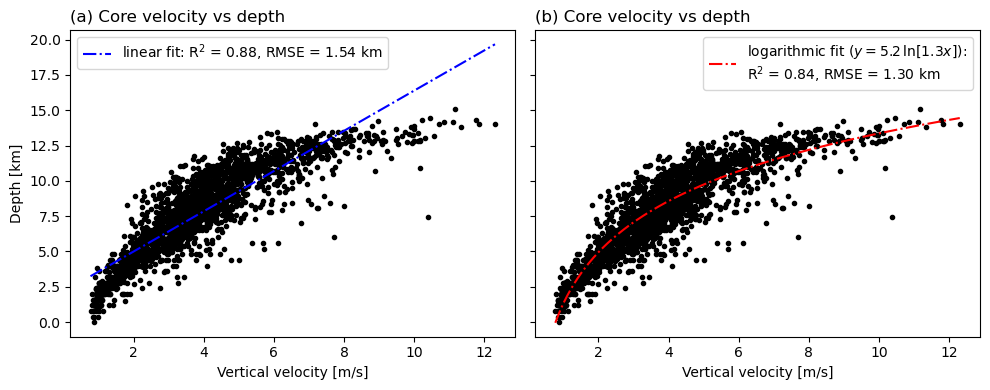

In [9]:
# fit a function to core velocity be depth
data = ds[['core_max_w','core_depth']].max('system').dropna('core', how='any')
xvals = data.core_max_w.values
yvals = data.core_depth.values

# sort to increasing
idx = np.argsort(xvals)
xvals = xvals[idx]
yvals = yvals[idx]

# fit logarithmic
def func(x, a, b):
    return a*np.log(b*x)
popt, pcov = scipy.optimize.curve_fit(func, xvals, yvals)
ypred = func(xvals, *popt)

# fit linear
coeff = np.polyfit(xvals, yvals, 1)
ylin = np.poly1d(coeff)(xvals)

# eval
r2 = metrics.r2_score(yvals, ypred)
rmse = metrics.root_mean_squared_error(yvals, ypred)
pearsons, _ = scipy.stats.pearsonr(xvals, yvals)
rmse_lin = metrics.root_mean_squared_error(yvals, ylin)

# view
fig, axs = plt.subplots(1,2,figsize=(10,4), sharey=1, layout='tight')

# linear
ax = axs[0]
ax.scatter(xvals, yvals, c='k', marker='.')
ax.plot(xvals, ylin, 'b-.', label=rf'linear fit: R$^2$ = {pearsons:.2f}, RMSE = {rmse_lin:.2f} km')
ax.legend()
ax.set(xlabel='Vertical velocity [m/s]', ylabel='Depth [km]')
ax.set_title('(a) Core velocity vs depth', loc='left')

# logarithmic
ax = axs[1]
ax.scatter(xvals, yvals, c='k', marker='.')
label = (
    rf'logarithmic fit ($y = {popt[0]:.1f}\,\ln[{popt[1]:.1f}x]$):'
    '\n'
    rf'R$^2$ = {r2:.2f}, RMSE = {rmse:.2f} km'
)
ax.plot(xvals, ypred, 'r-.', label=label)
ax.legend()
ax.set(xlabel='Vertical velocity [m/s]', )
ax.set_title('(b) Core velocity vs depth', loc='left')

# fig.savefig(savedir / f'convective_core_velocity_vs_depth.{ext}', dpi=dpi)

#### velocity and core area

Text(0.0, 1.0, '(a) Core velocity vs area')

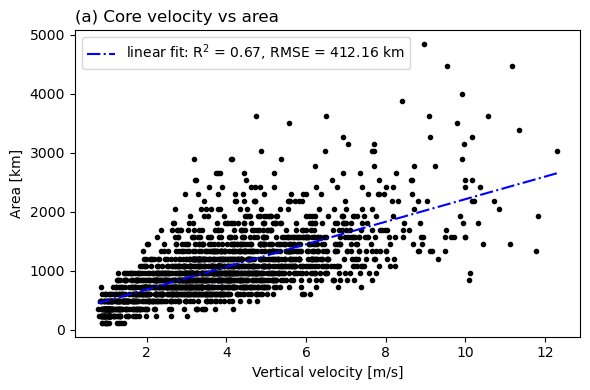

In [6]:
# fit a function to core velocity be depth
data = ds[['core_max_w','core_area']].max('system').dropna('core', how='any')
xvals = data.core_max_w.values
yvals = data.core_area.values

# sort to increasing
idx = np.argsort(xvals)
xvals = xvals[idx]
yvals = yvals[idx]

# fit linear
coeff = np.polyfit(xvals, yvals, 1)
ylin = np.poly1d(coeff)(xvals)

# eval
pearsons, _ = scipy.stats.pearsonr(xvals, yvals)
rmse_lin = metrics.root_mean_squared_error(yvals, ylin)

# view
fig, ax = plt.subplots(figsize=(6,4), sharey=1, layout='tight')

# linear
ax.scatter(xvals, yvals, c='k', marker='.')
ax.plot(xvals, ylin, 'b-.', label=rf'linear fit: R$^2$ = {pearsons:.2f}, RMSE = {rmse_lin:.2f} km')
ax.legend()
ax.set(xlabel='Vertical velocity [m/s]', ylabel='Area [km]')
ax.set_title('(a) Core velocity vs area', loc='left')


# fig.savefig(savedir / f'convective_core_velocity_vs_area.{ext}', dpi=dpi)

#### core velocity anvil area

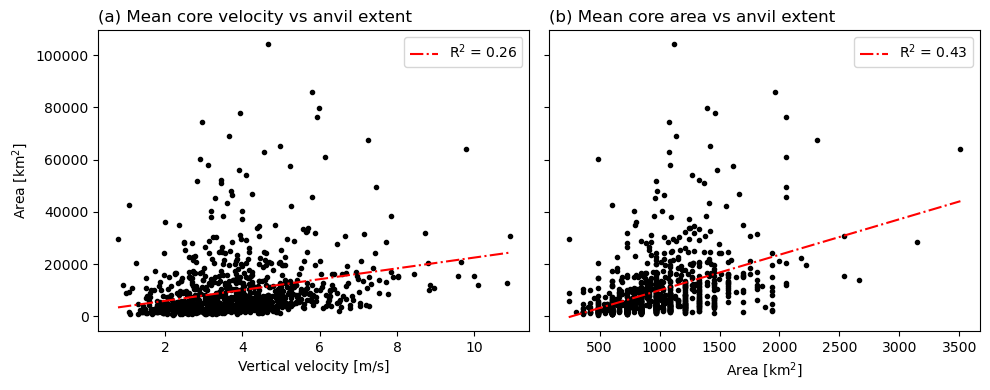

In [10]:
# correlation between to core velocity and area and anvil extent
data = ds[['core_max_w','cloud_area','core_area']].mean('core').max('interp_time').dropna('system', how='any')
wvals = data.core_max_w.values
acvals = data.core_area.values
yvals = data.cloud_area.values

# 1. results for core velocity

# sort to increasing
idx = np.argsort(wvals)
wvals = wvals[idx]
y1vals = yvals[idx]

# fit linear
coeff = np.polyfit(wvals, y1vals, 1)
y1lin = np.poly1d(coeff)(wvals)

# eval
pearsons1, _ = scipy.stats.pearsonr(wvals, y1vals)

# 2. results for core area

# sort to increasing
idx = np.argsort(acvals)
acvals = acvals[idx]
y2vals = yvals[idx]

# fit linear
coeff = np.polyfit(acvals, y2vals, 1)
y2lin = np.poly1d(coeff)(acvals)

# eval
pearsons2, _ = scipy.stats.pearsonr(acvals, y2vals)

# view
fig, axs = plt.subplots(1,2,figsize=(10,4), sharey=True, layout='tight')

# view result
ax = axs[0]
ax.scatter(wvals, y1vals, c='k', marker='.')
ax.plot(wvals, y1lin, 'r-.', label=rf'R$^2$ = {pearsons1:.2f}')
ax.legend()
ax.set(xlabel='Vertical velocity [m/s]', ylabel='Area [km$^2$]')
ax.set_title('(a) Mean core velocity vs anvil extent', loc='left')

ax = axs[1]
ax.scatter(acvals, y2vals, c='k', marker='.')
ax.plot(acvals, y2lin, 'r-.', label=rf'R$^2$ = {pearsons2:.2f}')
ax.legend()
ax.set(xlabel='Area [km$^2$]', )
ax.set_title('(b) Mean core area vs anvil extent', loc='left')

# fig.savefig(savedir / f'core_velocity_and_area_vs_anvil_extent.{ext}', dpi=dpi)

#### relative CMF changes in narrow and wide cores

In [6]:
# estimate the CMF as velocity X area
stats_ds = ds.copy()
stats_ds['cmf_est'] = (ds.core_max_w * ds.core_area)

In [7]:
def subset_by50pi(ds, variable):
    pi = ds[variable].quantile((0, 0.5, 1))
    below = ds.where(ds[variable] < pi.sel(quantile=0.5)).dropna('system')
    above = ds.where(ds[variable] >= pi.sel(quantile=0.5)).dropna('system')
    return below, above
    
def double_subset(ds, first, second):
    # subset 'first' by 50th percentile
    below, above = subset_by50pi(ds, first)
    # within each of the above, subset 'second' by its 50th percentile
    bb, ba = subset_by50pi(below, second)
    inner_below = xr.concat((bb, ba), dim=('lower','upper')).rename({'concat_dim':'pi_'+second})
    ab, aa = subset_by50pi(above, second)
    inner_above =  xr.concat((ab, aa), dim=('lower','upper')).rename({'concat_dim':'pi_'+second})
    # as one dataset
    result = xr.concat((inner_below, inner_above), dim=('lower','upper')).rename({'concat_dim':'pi_'+first})
    return result

In [9]:
# A - group systems as narrow or wide
gds = stats_ds.mean('core').rename({'core_area':'Ac','core_max_w':'w'}).compute()
partition_by_size = double_subset(gds, 'Ac', 'w')
narrow = partition_by_size.sel(pi_Ac='lower')
wide = partition_by_size.sel(pi_Ac='upper')

In [10]:
# B - group strong and weak cases within narrow cores
weak_narrow = narrow.sel(pi_w='lower')
strong_narrow = narrow.sel(pi_w='upper')

In [11]:
# C - group strong and weak cases within wide cores
weak_wide = wide.sel(pi_w='lower')
strong_wide = wide.sel(pi_w='upper')

In [12]:
# plot PDFs
def compare_characeristics(data1, data2, name1, name2, vars_to_plot, axs=None):
    if not axs:
        fig, axs = plt.subplots(1,len(vars_to_plot), figsize=(4*len(vars_to_plot),3.5), layout='tight')

    if not isinstance(axs, np.ndarray):
        flat = [axs]
    else:
        flat = axs.flat
    for ax, var in zip(flat, vars_to_plot):
        if 'interp_time' in data1[var].dims:
            vals1 = data1[var].max('interp_time')
            vals2 = data2[var].max('interp_time')
        else:
            vals1 = data1[var]
            vals2 = data2[var]
            
        vals1 = vals1.values.ravel()
        vals2 = vals2.values.ravel()
    
        # view
        all_vals = np.concatenate([vals1, vals2])
        all_vals = all_vals[~np.isnan(all_vals)]
        bins = np.linspace(all_vals.min(), all_vals.max(), 15)
        ax.hist(vals1, bins=bins, histtype='step', ec='k', density=True, label=name1)
        ax.hist(vals2, bins=bins, histtype='step', ec='r', density=True, label=name2)
        ax.set_title(var)
        ax.legend()
    return ax

<Axes: title={'center': 'n_cores'}>

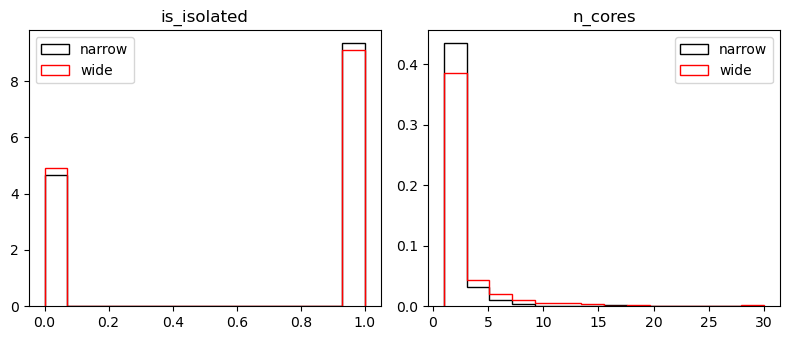

In [13]:
# 1 . no significant change in organisation

vars_to_plot = ['is_isolated','n_cores',]
compare_characeristics(narrow, wide, 'narrow', 'wide', vars_to_plot)

<Axes: title={'center': 'cmf_est'}>

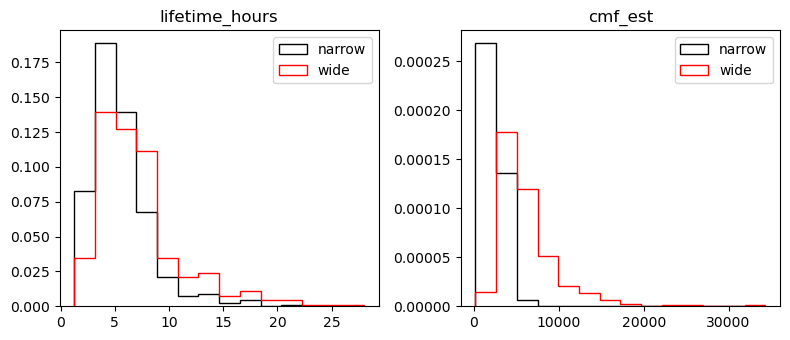

In [14]:
# 2. narrow cases tended to live less long and have lower CMF

vars_to_plot = ['lifetime_hours','cmf_est',]
compare_characeristics(narrow, wide, 'narrow', 'wide', vars_to_plot)

In [15]:
# 3a. quantify the % change in anvil area in response to increased w in narrow vs wide cores

def percent_chage(weak_val, strong_val):
    return ((strong_val - weak_val) / weak_val).values
    
pct_change_narrow = percent_chage(weak_narrow.cloud_area.mean('system').max('interp_time'), strong_narrow.cloud_area.mean('system').max('interp_time'))
pct_change_wide = percent_chage(weak_wide.cloud_area.mean('system').max('interp_time'), strong_wide.cloud_area.mean('system').max('interp_time'))

print(pct_change_narrow)
print(pct_change_wide)

0.10182667799490261
0.41659586519399605


In [21]:
# 3b. compare to the % change in the estimated CMT

cmf_change_narrow = percent_chage(weak_narrow.cmf_est.mean(), strong_narrow.cmf_est.mean())
cmf_change_wide = percent_chage(weak_wide.cmf_est.mean(), strong_wide.cmf_est.mean())

print(pct_change_narrow)
print(pct_change_wide)


0.8946904844171913
0.9976259636736292


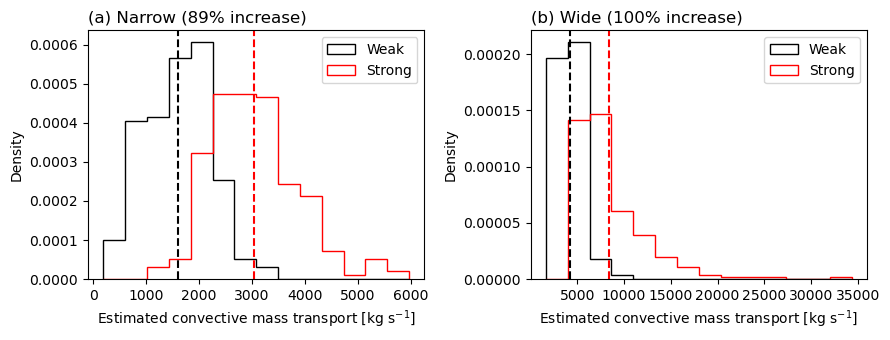

In [22]:
# 3c. figure

vars_to_plot = ['cmf_est']

fig, axs = plt.subplots(1,2, figsize=(9,3.5), layout='tight')

# - create
ax1 = compare_characeristics(weak_narrow, strong_narrow, 'Weak', 'Strong', vars_to_plot, axs=axs[0])
ax2 = compare_characeristics(weak_wide, strong_wide, 'Weak', 'Strong', vars_to_plot, axs=axs[1])

# - format
for ax in (ax1, ax2):
    ax.set(xlabel='Estimated convective mass transport [kg s$^{-1}$]', ylabel='Density', title='')
ax1.set_title(f'(a) Narrow ({cmf_change_narrow*100:.0f}% increase)', loc='left')
ax2.set_title(f'(b) Wide ({cmf_change_wide*100:.0f}% increase)', loc='left')

# - mean
ax1.axvline(weak_narrow.cmf_est.mean(), c='k', ls='--')
ax1.axvline(strong_narrow.cmf_est.mean(), c='r', ls='--')
ax2.axvline(weak_wide.cmf_est.mean(), c='k', ls='--')
ax2.axvline(strong_wide.cmf_est.mean(), c='r', ls='--')

# fig.savefig(savedir / f'change_in_estimated_cmt.{ext}', dpi=dpi)

<Axes: title={'center': 'core_pr'}>

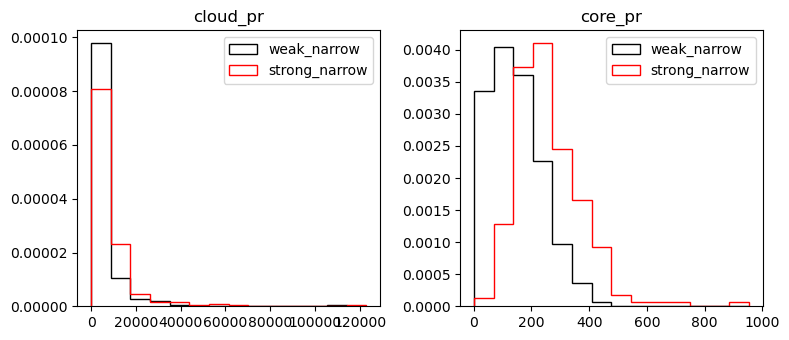

In [23]:
# 4. relative response of precipitation

vars_to_plot = ['cloud_pr','core_pr',]
compare_characeristics(weak_narrow, strong_narrow, 'weak_narrow', 'strong_narrow', vars_to_plot)

<Axes: title={'center': 'core_pr'}>

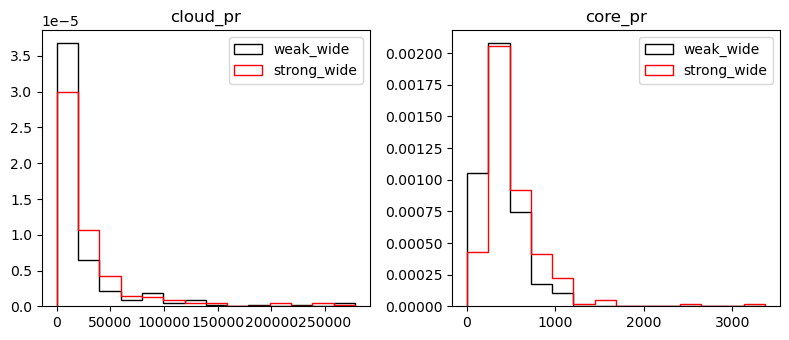

In [24]:
vars_to_plot = ['cloud_pr','core_pr',]
compare_characeristics(weak_wide, strong_wide, 'weak_wide', 'strong_wide', vars_to_plot)

In [26]:
# - response

pct_change_weak = percent_chage(weak.sel(pi_Ac='lower').core_pr.mean('system'), weak.sel(pi_Ac='upper').core_pr.mean('system'))
pct_change_strong = percent_chage(strong.sel(pi_Ac='lower').core_pr.mean('system'), strong.sel(pi_Ac='upper').core_pr.mean('system'))

print(pct_change_weak)
print(pct_change_strong)

1.1302617
0.7042174


In [19]:
# 5. relative responses when partitioned first by core intensity

partition_by_intensity = double_subset(gds, 'w', 'Ac')
weak = partition_by_intensity.sel(pi_w='lower')
strong = partition_by_intensity.sel(pi_w='upper')

In [20]:
# - response

pct_change_weak = percent_chage(weak.sel(pi_Ac='lower').cloud_area.mean('system').max('interp_time'), weak.sel(pi_Ac='upper').cloud_area.mean('system').max('interp_time'))
pct_change_strong = percent_chage(strong.sel(pi_Ac='lower').cloud_area.mean('system').max('interp_time'), strong.sel(pi_Ac='upper').cloud_area.mean('system').max('interp_time'))

print(pct_change_weak)
print(pct_change_strong)

0.8633365713993567
1.058603913474053
